In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits


In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:

import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(
    title,
    data,
    labels,
    colors,
    alphas,
    ax=None
):
    # number of variable
    categories=list(data[0].tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    if ax is None:
        fig = plt.figure(figsize=(12, 12))
        ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([item.replace("_", " ") for item in data[0].index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item / 10 for item in range(0, 55, 10)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    
    max_val = max([item.max() for item in data])
    ax.set_ylim(0, max_val)
    ax.spines['polar'].set_visible(False)

    ax.set_title(title, color='black', size=20, pad=20)
    
    for i in range(len(data)):
    
        cur_data = data[i]
        values=cur_data.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
        ax.fill(angles, values, colors[i], alpha=alphas[i])
    
    legend = ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    
    #ax.set_yticks([item for item in range(0, 45, 10)])
    #ax.set_yticklabels([f"{item}" for item in range(0, 45, 10)], size=12)


    ax.set_frame_on(False)
    ax.set_axisbelow(True)
    #ax.set_facecolor(bball_gray)
    #fig.set_facecolor(bball_gray)

In [7]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

play_types_seasons = {}


    
def download_play_type_data(season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    return play_type_dict




In [8]:
def get_interesting_data(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["PLAYER_NAME", target_column]
        result = df[play].loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='PLAYER_NAME', how='outer')
    return final_df


def get_merged_data(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    
    
    first_df = get_interesting_data(first_year, target_column)
    second_df = get_interesting_data(second_year, target_column)
    merged_df = pd.merge(left=first_df, right=second_df, on='PLAYER_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

In [9]:
df = download_play_type_data(season='2020-21')

Retrieving play types...


In [10]:
data_type = 'POSS_PCT'
pt = get_interesting_data(df, data_type).fillna(0.0)

In [86]:
player_name = 'Giannis Antetokounmpo'

In [11]:
#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'Chris Paul'
player_two = 'Devin Booker'

first_df = pt.loc[pt.PLAYER_NAME == player_one]
second_df = pt.loc[pt.PLAYER_NAME == player_two]

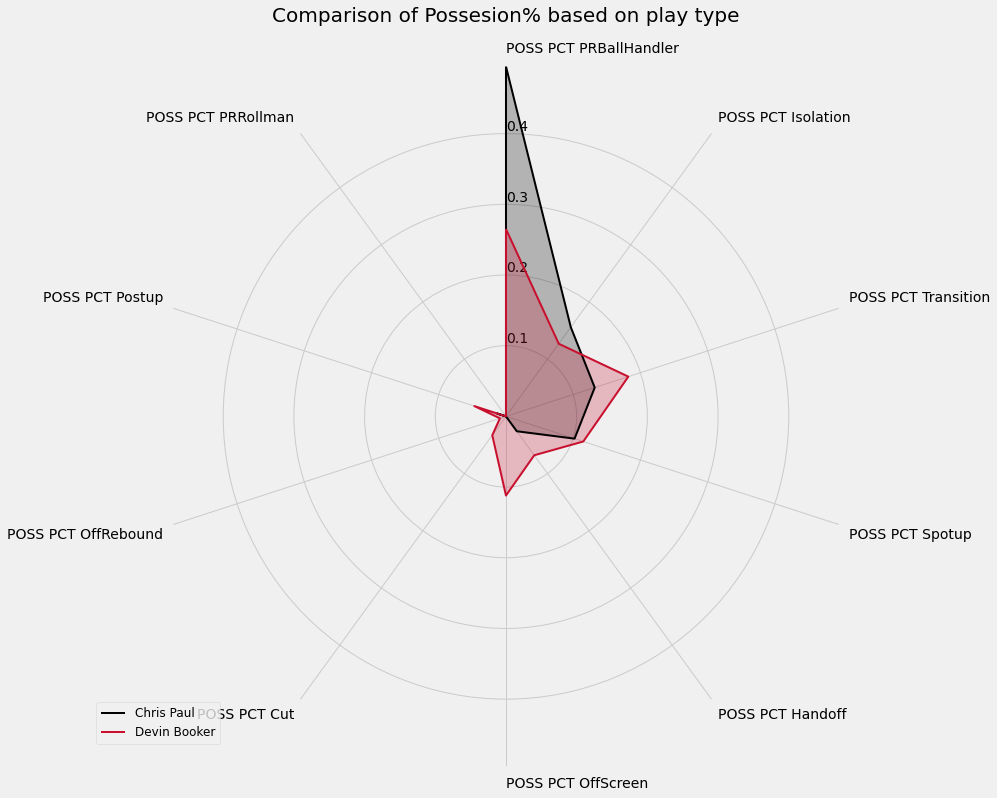

In [14]:
plot_radar(
    title="Comparison of Possesion% based on play type",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=[player_one, player_two],
    colors=[
        "#000000",
        "#C8102E",
    ],
    alphas=[0.25, 0.25, 0.25]
)

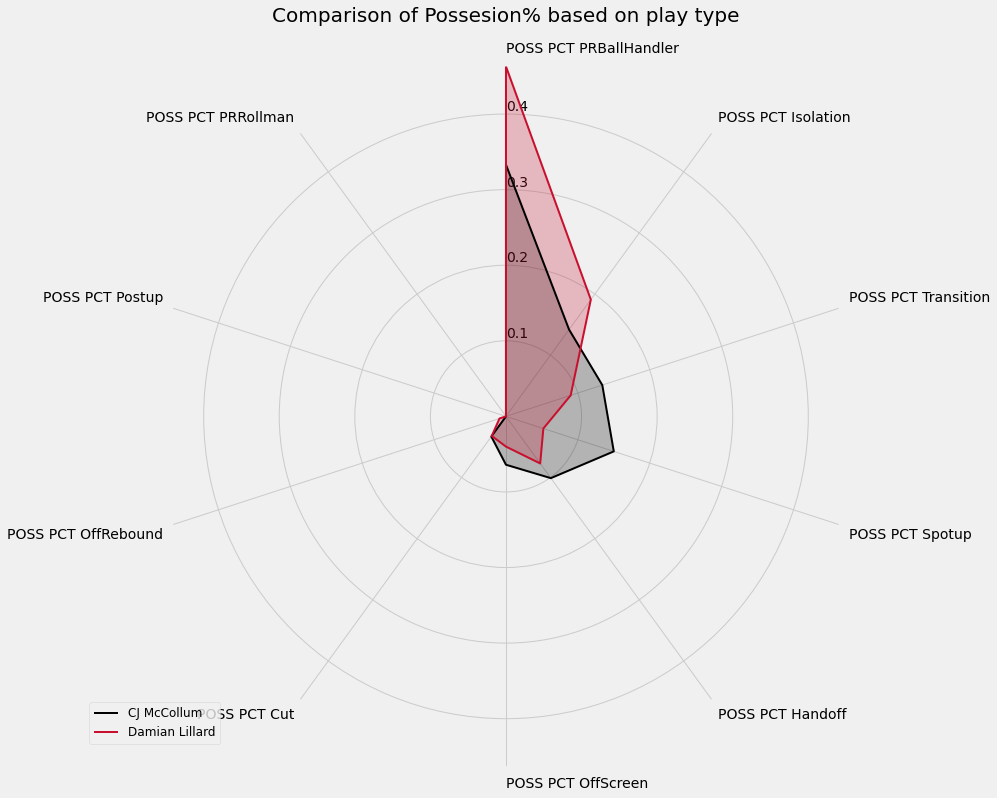

In [15]:
#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'CJ McCollum'
player_two = 'Damian Lillard'

first_df = pt.loc[pt.PLAYER_NAME == player_one]
second_df = pt.loc[pt.PLAYER_NAME == player_two]

plot_radar(
    title="Comparison of Possesion% based on play type",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=[player_one, player_two],
    colors=[
        "#000000",
        "#C8102E",
    ],
    alphas=[0.25, 0.25, 0.25]
)

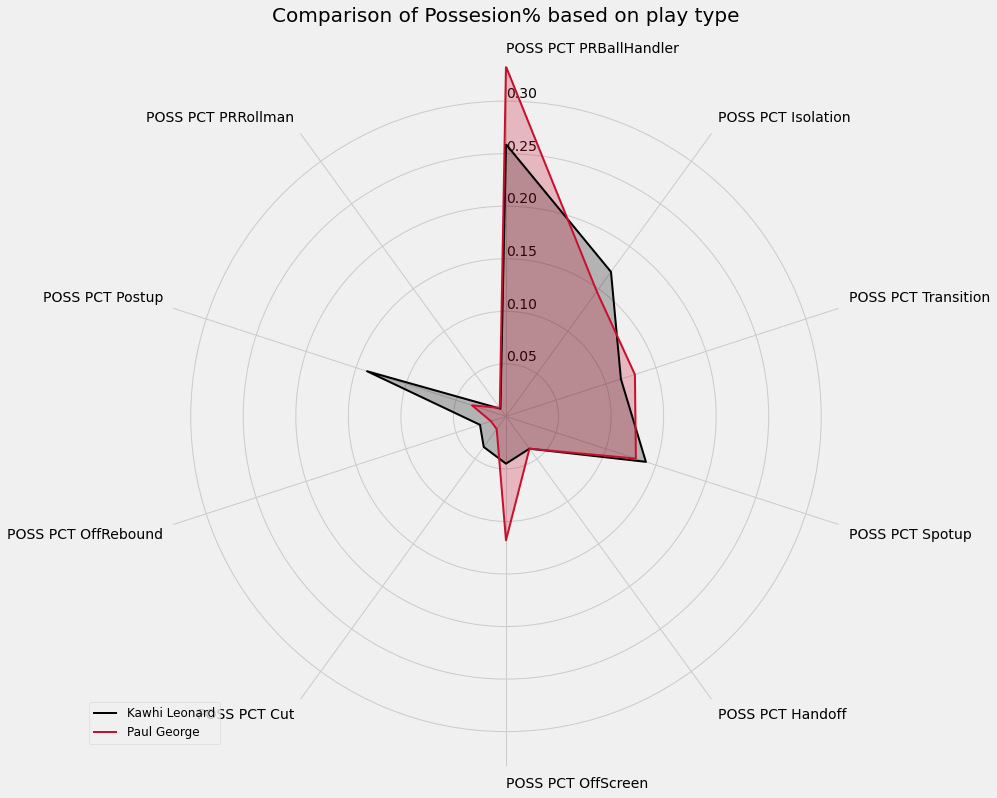

In [16]:
#giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
player_one =  'Kawhi Leonard'
player_two = 'Paul George'

first_df = pt.loc[pt.PLAYER_NAME == player_one]
second_df = pt.loc[pt.PLAYER_NAME == player_two]

plot_radar(
    title="Comparison of Possesion% based on play type",
    data=[first_df.iloc[0][1:], second_df.iloc[0][1:]],
    labels=[player_one, player_two],
    colors=[
        "#000000",
        "#C8102E",
    ],
    alphas=[0.25, 0.25, 0.25]
)